# 1. Introduction

This model is based on encoder-decoder structure. And is uesd for French-English translation tasks.

The model added the attention mechanism, and used two generation methods: greedy and beam search

# 2.Data preprocessing

## 2.1 Import related packages

In [170]:
from io import open
import unicodedata
import string
import re
import random

#Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.utils.data as DataSet

# draw
import matplotlib.pyplot as plt
import numpy as np

# GPU
use_cuda = torch.cuda.is_available()

## 2.2Prepare parallel corpus

In [171]:
# Define two special symbols, corresponding to the beginning and end of the sentence
SOS_token = 0
EOS_token = 1

lines = open('fra.txt', encoding = 'utf-8')
french = lines.read().strip().split('\n')
lines = open('eng.txt', encoding = 'utf-8')
english = lines.read().strip().split('\n')
print(len(french))
print(len(english))

135842
135842


In [172]:
# Two dictionaries：word2index，index2word
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        # Add a new sentence to the language, a sentence is a set of words separated by spaces
        # Segment the words and process them separately
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        # Insert a word, if the word is already in the dictionary, update the frequency of the corresponding word in the dictionary
        # Create a reverse index at the same time, you can find the word from the word number
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [173]:
# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Remove special symbols and convert English strings to lowercase
def normalizeEngString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Filter the input word pairs to ensure that the number of words in each sentence cannot exceed MAX_LENGTH
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

# Input a sentence, output a code sequence corresponding to a word
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


# Similar to the function above, the difference is that the output sequence is the same length = MAX_LENGTH
def indexFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    for i in range(MAX_LENGTH - len(indexes)):
        indexes.append(EOS_token)
    return(indexes)

# From a word pair to a subscript
def indexFromPair(pair):
    input_variable = indexFromSentence(input_lang, pair[0])
    target_variable = indexFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

def SentenceFromList(lang, lst):
    result = [lang.index2word[i] for i in lst if i != EOS_token]
    if lang.name == 'French':
        result = ' '.join(result)
    else:
        result = ' '.join(result)
    return(result)

In [174]:
# Functions for calculating accuracy
def rightness(predictions, labels):
    # For the first dimension of the output value of any row (a sample), find the maximum and get the subscript of the largest element in each row
    pred = torch.max(predictions.data, 1)[1] 
    #Compare the subscripts with the categories contained in the labels, and accumulate the correct number
    rights = pred.eq(labels.data).sum() 
    #Return the correct number and how many elements have been compared this time
    return rights, len(labels)

## 2.3 Split Data Set

In [175]:
# Set the maximum length of sentences
MAX_LENGTH = 5

pairs = [[normalizeEngString(fra), normalizeEngString(eng)] for fra, eng in zip(french, english)]

# Filter sentence pairs, and deal with sentences that exceed MAX_LENGTH length
input_lang = Lang('French')
output_lang = Lang('English')
pairs = [pair for pair in pairs if filterPair(pair)]
print('Valid sentence pairs：', len(pairs))

# Create two dictionaries (French and English)
for pair in pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])
print("Total words:")
print(input_lang.name, input_lang.n_words)
print(output_lang.name, output_lang.n_words)


# Form the training set, first, disrupt the order of all sentences
random_idx = np.random.permutation(range(len(pairs)))
pairs = [pairs[i] for i in random_idx]

# Sentence id formed by encoding the language into words
pairs = [indexFromPair(pair) for pair in pairs]

# Form training set, verification set and test set
valid_size = len(pairs) // 10
if valid_size > 10000:
    valid_size = 10000

valid_pairs = pairs[-valid_size : -valid_size // 2]
test_pairs = pairs[- valid_size // 2 :]
pairs = pairs[ : - valid_size]

# Use PyTorch's dataset and dataloader objects to load the data into the loader and automatically batch

batch_size = 512 

print('Training   set samples：', len(pairs))
print('Validation set samples：', len(valid_pairs))
print('Test       set samples：', len(test_pairs))

# Form a list of training pairs for feeding to train_dataset
pairs_X = [pair[0] for pair in pairs]
pairs_Y = [pair[1] for pair in pairs]
valid_X = [pair[0] for pair in valid_pairs]
valid_Y = [pair[1] for pair in valid_pairs]
test_X = [pair[0] for pair in test_pairs]
test_Y = [pair[1] for pair in test_pairs]


# Training   set
train_dataset = DataSet.TensorDataset(torch.LongTensor(pairs_X), torch.LongTensor(pairs_Y))
train_loader = DataSet.DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# Validation set
valid_dataset = DataSet.TensorDataset(torch.LongTensor(valid_X), torch.LongTensor(valid_Y))
valid_loader = DataSet.DataLoader(valid_dataset, batch_size = batch_size, shuffle = True, num_workers=8)

# Test       set
test_dataset = DataSet.TensorDataset(torch.LongTensor(test_X), torch.LongTensor(test_Y))
test_loader = DataSet.DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 8)

Valid sentence pairs： 5423
Total words:
French 2851
English 1703
Training   set samples： 4881
Validation set samples： 271
Test       set samples： 271


# 3. Encoder-decoder model

## 3.1 Implementation of the encoder

In [135]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first = True, 
                          num_layers = self.n_layers, bidirectional = True)

    def forward(self, input, hidden):
        #input： batch_size, length_seq
        embedded = self.embedding(input)
        #embedded：batch_size, length_seq, hidden_size
        output = embedded
        output, hidden = self.gru(output, hidden)
        # output：batch_size, length_seq, hidden_size
        # hidden：num_layers * directions, batch_size, hidden_size
        return output, hidden

    def initHidden(self, batch_size):
        #num_layers * num_directions, batch, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## 3.2 Implementation of the decoder

In [136]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)

        # from （hidden_size * (2 * layers+ 1) to   the maximum sequence length
        self.attn = nn.Linear(self.hidden_size * (2 * n_layers + 1), self.max_length)

        #The result of the attention mechanism       hidden_size * 3， project to      hidden_size
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)

        # dropout
        self.dropout = nn.Dropout(self.dropout_p)


        # Define a bidirectional GRU, and is set to True to facilitate the operation batch_first
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, bidirectional = True,
                         num_layers = self.n_layers, batch_first = True)
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)
        #hidden_size * 3， project to      output_size (Dictionary size)

    def forward(self, input, hidden, encoder_outputs):
        # input：batch_size, length_seq
        embedded = self.embedding(input)
        # embedded：batch_size, length_seq, hidden_size
        embedded = embedded[:, 0, :]
        # embedded：batch_size, hidden_size  
        embedded = self.dropout(embedded)


        # encoder_hidden：direction*n_layer, batch_size, hidden_size
        # hidden：direction*n_layer, batch_size, hidden_size
        temp_for_transpose = torch.transpose(hidden, 0, 1).contiguous()
        # After transpose, permute and other dimensional transformation operations, tensor is no longer continuously stored in memory, 
        # and view operations require continuous storage in tensor memory, so contiguous is required to return a contiguous copy;
        # hidden：batch_size, direction*n_layer, hidden_size
        temp_for_transpose = temp_for_transpose.view(temp_for_transpose.size()[0], -1)
        hidden_attn = temp_for_transpose
        # hidden_attn：batch_size, direction*n_layers*hidden_size
        input_to_attention = torch.cat((embedded, hidden_attn), 1)   
        # input_to_attention：batch_size, hidden_size * (1 （The output of the last layer of encoder）+ direction * n_layers)

        # The weight of the attention layer output
        attn_weights = F.softmax(self.attn(input_to_attention))
        # attn_weights：batch_size, max_length

        # When the input data is not of equal length, cut the necessary section of weights. 
        # The sentence may not be long enough, so do not consider the weight of the padding part
        # encoder_outputs：batch_size, length_seq, hidden_size*direction        encoder_outputs.size()[1]  =  length_seq
        attn_weights = attn_weights[:, : encoder_outputs.size()[1]]
        # attn_weights：batch_size, length_seq_of_encoder
        attn_weights = attn_weights.unsqueeze(1)
        # attn_weights：batch_size, 1, length_seq       1 for bmm

        # encoder_outputs：batch_size, seq_length, hidden_size*direction
        attn_applied = torch.bmm(attn_weights, encoder_outputs) 
        # attn_applied：batch_size, 1, hidden_size*direction

        # concate the input word vector and the result of the attention mechanism into a large input vector
        output = torch.cat((embedded, attn_applied[:,0,:]), 1)
        # output大小：batch_size, hidden_size * (direction + 1)

        output = self.attn_combine(output).unsqueeze(1)
        # output：batch_size, 1, hidden_size
        # output：batch_size, length_seq, hidden_size
        output = F.relu(output)

        output = self.dropout(output)
        output, hidden = self.gru(output, hidden)

        # output：batch_size, length_seq, hidden_size * directions
        # hidden：n_layers * directions, batch_size, hidden_size             

        #Take the result of the last step of the GRU operation and feed it to the last layer of the fully linked layer
        output = self.out(output[:, -1, :])     #input    batch_size,  hidden_size * 2   
        # output：batch_size * output_size

        # logsoftmax
        output = F.log_softmax(output, dim = 1)    
        # output：batch_size * output_size     The element is the probability value of all words in the dictionary at a certain moment
        # hidden: n_layers * directions, batch_size, hidden_size     Latent variables of all layers and all directions at the last moment 
        # attn_weights：batch_size, 1, length_seq          1 for bmm
        return output, hidden, attn_weights

    def initHidden(self, batch_size):
        # n_layers * directions, batch_size, hidden_size
        result = Variable(torch.zeros(self.n_layers * 2, batch_size, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

## 3.3 Start training

### 3.3.1 Instantiate encoder, decoder, define optimizer, loss function and other components

In [141]:
hidden_size = 256
max_length = MAX_LENGTH
n_layers = 1
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers = n_layers)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.5,
                         max_length = max_length, n_layers = n_layers)

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

learning_rate = 0.001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.NLLLoss()
teacher_forcing_ratio = 0.5

### 3.3.2 Define the training function

In [142]:
plot_losses = []

print_loss_total = 0

print_loss_avg = 0

def train_attention_model():
    global plot_losses
    global print_loss_total
    global print_loss_avg
    print_loss_total = 0


    for data in train_loader:    
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable：batch_size, length_seq      
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable：batch_size, length_seq

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0

        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs：batch_size, length_seq, hidden_size*direction
        # encoder_hidden：direction*n_layer, batch_size, hidden_size


        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input


        decoder_hidden = encoder_hidden
        # decoder_hidden：direction*n_layer, batch_size, hidden_size

        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        if use_teacher_forcing:

            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)

                loss += criterion(decoder_output, target_variable[:, di])
                decoder_input = target_variable[:, di].unsqueeze(1)  # Teacher forcing
                # decoder_input：batch_size, length_seq
        else:
            for di in range(MAX_LENGTH):
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #decoder_ouput：batch_size, output_size(vocab_size)
                topv, topi = decoder_output.data.topk(1, dim = 1)
                #topi ：batch_size, k
                ni = topi[:, 0]

                decoder_input = Variable(ni.unsqueeze(1))
                # decoder_input：batch_size, length_seq
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input

                loss += criterion(decoder_output, target_variable[:, di])

        loss.backward()
        loss = loss.cpu() if use_cuda else loss
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        print_loss_total += loss.data.numpy()

    print_loss_avg = print_loss_total / len(train_loader)

### 3.3.3 Model verification function

In [143]:
valid_loss = 0
rights = []

def evaluation_attention_model():
    global valid_loss
    global rights
    valid_loss = 0
    rights = []


    for data in valid_loader:
        input_variable = Variable(data[0]).cuda() if use_cuda else Variable(data[0])
        # input_variable：batch_size, length_seq
        target_variable = Variable(data[1]).cuda() if use_cuda else Variable(data[1])
        # target_variable：batch_size, length_seq

        encoder_hidden = encoder.initHidden(data[0].size()[0])

        loss = 0
        encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
        # encoder_outputs：batch_size, length_seq, hidden_size*direction
        # encoder_hidden：direction*n_layer, batch_size, hidden_size

        decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))
        # decoder_input：batch_size, length_seq
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

        decoder_hidden = encoder_hidden
        # decoder_hidden：direction*n_layer, batch_size, hidden_size

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            #decoder_ouput：batch_size, output_size(vocab_size)
            topv, topi = decoder_output.data.topk(1, dim = 1)
            #topi ：batch_size, k
            ni = topi[:, 0]

            decoder_input = Variable(ni.unsqueeze(1))
            # decoder_input：batch_size, length_seq
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            right = rightness(decoder_output, target_variable[:, di])
            rights.append(right)
            loss += criterion(decoder_output, target_variable[:, di])
        loss = loss.cpu() if use_cuda else loss
        valid_loss += loss.data.numpy()

### 3.3.4 Start training

In [144]:
num_epoch = 100

plot_losses = []
for epoch in range(num_epoch):
    decoder.train()
    
    learning_rate = learning_rate -epoch * 0.00001
    #reduce teacher_forcing_ratio gruadually
    teacher_forcing_ratio = teacher_forcing_ratio - epoch * 0.05

    print_loss_total = 0

    train_attention_model()

    # close dropout
    decoder.eval()

    evaluation_attention_model()
      
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('Process：%d%% Train-loss：%.4f，Valid-loss：%.4f，Word Accuracy：%.2f%%' % (epoch * 1.0 / num_epoch * 100, 
                                                    print_loss_avg,
                                                    valid_loss / len(valid_loader),
                                                    100.0 * right_ratio))
    plot_losses.append([print_loss_avg, valid_loss / len(valid_loader), right_ratio])

C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Process：0% Train-loss：30.0765，Valid-loss：24.3053，Word Accuracy：51.45%
Process：1% Train-loss：21.7781，Valid-loss：20.5314，Word Accuracy：56.37%
Process：2% Train-loss：18.0869，Valid-loss：18.0186，Word Accuracy：60.31%
Process：3% Train-loss：15.4811，Valid-loss：15.9831，Word Accuracy：62.94%
Process：4% Train-loss：13.2895，Valid-loss：14.5060，Word Accuracy：65.23%
Process：5% Train-loss：11.3065，Valid-loss：13.5635，Word Accuracy：67.32%
Process：6% Train-loss：9.6616，Valid-loss：12.7669，Word Accuracy：68.35%
Process：7% Train-loss：8.2814，Valid-loss：12.3477，Word Accuracy：69.52%
Process：8% Train-loss：7.1224，Valid-loss：12.0246，Word Accuracy：70.77%
Process：9% Train-loss：6.1938，Valid-loss：11.8832，Word Accuracy：71.05%
Process：10% Train-loss：5.4108，Valid-loss：11.7413，Word Accuracy：71.79%
Process：11% Train-loss：4.7758，Valid-loss：11.7512，Word Accuracy：71.89%
Process：12% Train-loss：4.2358，Valid-loss：11.7439，Word Accuracy：72.37%
Process：13% Train-loss：3.7895，Valid-loss：11.8882，Word Accuracy：72.23%
Process：14% Train-loss：3

KeyboardInterrupt: 

### 3.3.5 Save Model

In [145]:
torch.save(encoder,'encoder_attention2.mdl')
torch.save(decoder,'decoder_attention2.mdl')

### 3.3.6 Load Model

In [146]:
encoder = torch.load("encoder_attention2.mdl")
decoder = torch.load("decoder_attention2.mdl")

if use_cuda:
    encoder = encoder.cuda()
    decoder = decoder.cuda()

### 3.3.7 Drawing the training error curve of the model

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\multiprocessing\queues.py", line 232, in _feed
    close()
  File "C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\multiprocessing\connection.py", line 177, in close
    self._close()
  File "C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\multiprocessing\connection.py", line 277, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] 句柄无效。

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\multiprocessing\queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many t

<IPython.core.display.Javascript object>


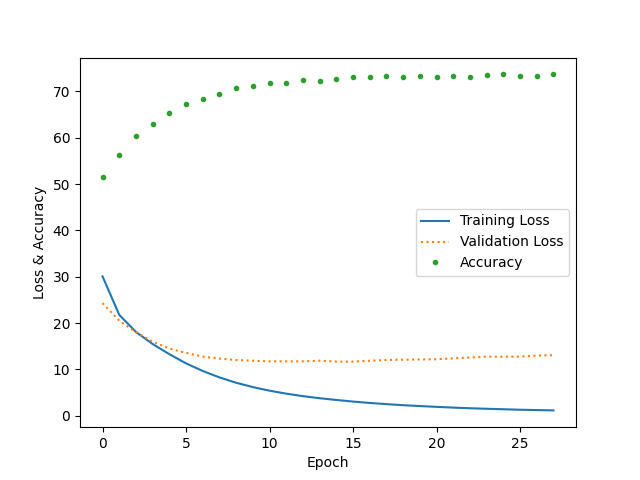

In [147]:
%matplotlib notebook
a = [i[0] for i in plot_losses]
b = [i[1] for i in plot_losses]
c = [i[2] * 100 for i in plot_losses]
plt.plot(a, '-', label = 'Training Loss')
plt.plot(b, ':', label = 'Validation Loss')
plt.plot(c, '.', label = 'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss & Accuracy')
plt.legend()

## 3.4 Test model

In [150]:
# Randomly select 5 sentences from the test set to test the translation results
indices = np.random.choice(range(len(test_X)), 5)
indices

array([1305,  410,  199, 1414, 2472])

In [165]:
for ind in indices:      
    data = [test_X[ind]]
    target = [test_Y[ind]]
    #print('input id',data[0])
    
    input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
    # input_variable：batch_size, length_seq
    target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
    # target_variable：batch_size, length_seq
    #print('input_variable', target_variable.size())     #([1, 10])
    #print('target id',target[0])
    #print('target sentence',SentenceFromList(output_lang, target[0]))
    #print('target_variable', target_variable.size())
    encoder_hidden = encoder.initHidden(input_variable.size()[0])

    loss = 0
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    # encoder_outputs：batch_size, length_seq, hidden_size*direction
    # encoder_hidden：direction*n_layer, batch_size, hidden_size

    decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))     #target_variable.size()[0]  = batch_size
    #print('decoder_input: ',decoder_input)
    # decoder_input：二维tensor batch_size*1   
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden
    # decoder_hidden：direction*n_layer, batch_size, hidden_size
    #print('decoder_hidden: ',decoder_hidden)       # 2 * 1*  32
    # Without teacher forcing: use its own predictions as the next input
    output_sentence = []
    decoder_attentions = torch.zeros(max_length, max_length)
    rights = []
    for di in range(MAX_LENGTH):      #every time-step    decoder_input has only one possibility
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        #decoder_ouput：batch_size, output_size(vocab_size)
        #print('decoder_output',decoder_output.size())
        #print('decoder_output',decoder_output)
        topv, topi = decoder_output.data.topk(1, dim = 1)
        #print('topv:',topv ,'topi',topi)
        decoder_attentions[di] = decoder_attention.data
        ni = topi[:, 0]
        #print('ni:', ni)
        #print(decoder_input)
        decoder_input = Variable(ni.unsqueeze(1))
        #print(decoder_input)
        ni = ni.cpu().numpy()[0]
        output_sentence.append(ni)
        #print('output_sentence', output_sentence)
        # decoder_input：batch_size, length_seq
        #print('decoder_input: ',decoder_input)
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
        right = rightness(decoder_output, target_variable[:, di])
        rights.append(right)
    
    sentence = SentenceFromList(output_lang, output_sentence)
    standard = SentenceFromList(output_lang, target[0])
    print('input        sentence: ',SentenceFromList(input_lang, data[0]))
    print('model     translation：', sentence)
    print('reference translation：', standard)
    right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
    print('Word accuracy：', 100.0 * right_ratio.cpu().numpy())
    print('\n')

input        sentence:  ne dites rien a ma nana !
model     translation： don t tell my girlfriend .
reference translation： don t tell my girlfriend .
Word accuracy： 100.0


input        sentence:  il se mit au lit .
model     translation： he went to bed bed .
reference translation： he got into bed .
Word accuracy： 50.0


input        sentence:  mes voisines sont mes amies .
model     translation： my friends are my friends .
reference translation： my neighbors are my friends .
Word accuracy： 87.5


input        sentence:  je vais te rendre heureux .
model     translation： i ll make you happy .
reference translation： i ll make you happy .
Word accuracy： 100.0


input        sentence:  quelle est votre valise ?
model     translation： which is your suitcase ?
reference translation： which is your luggage ?
Word accuracy： 87.5




C:\Users\mk632\Anaconda3\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [152]:
from numpy import array
from numpy import argmax
from math import log 
from queue import PriorityQueue

In [153]:
def beam_search_decoder(data, k):     #data   beam size       
    global sequences
    #print(len(sequences[idx]) ,len(sequences[idx]),sequences[idx])
    score,seq  = sequences[idx][beam]       
    for j in range(len(data)):   #The number of loops is equal to the dictionary size 
        candidate = [(score - (data[j])),seq + [j], ]  #candidate The score of the location and the location index of the expanded storage history path
        all_candidates.put(candidate)        #all_candidates stores the score and position index of all words in the current time-step
        beam_candidates.put(candidate)
    return sequences

In [ ]:
# Define the beam size
beam_width = 3      

for ind in indices:
    data = [test_X[ind]]
    target = [test_Y[ind]]
    input_sentence = SentenceFromList(input_lang, data[0])
    standard = SentenceFromList(output_lang, target[0])
    print('input id',data[0])
    print('input sentence',input_sentence)
    input_variable = Variable(torch.LongTensor(data)).cuda() if use_cuda else Variable(torch.LongTensor(data))
    # input_variable：batch_size, length_seq
    target_variable = Variable(torch.LongTensor(target)).cuda() if use_cuda else Variable(torch.LongTensor(target))
    # target_variable：batch_size, length_seq

    encoder_hidden = encoder.initHidden(input_variable.size()[0])

    loss = 0
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    # encoder_outputs：batch_size, length_seq, hidden_size*direction
    # encoder_hidden：direction*n_layer, batch_size, hidden_size
    #print('target_variable', target_variable.size()[0])
    decoder_input = Variable(torch.LongTensor([[SOS_token]] * target_variable.size()[0]))     #target_variable.size()[0]  = batch_size
    # decoder_input：batch_size,   
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    print('decoder_input',decoder_input)
    decoder_hidden = encoder_hidden
    # decoder_hidden：direction*n_layer, batch_size, hidden_size
    decoder_input_beam = [[decoder_input]]
    # Without teacher forcing: use its own predictions as the next input
    decoder_attentions = torch.zeros(max_length, max_length)
    topk = [[]]
    sequences = []   #Store batch_size sentences
    for idx in range(decoder_output.size(0)):      #For every sentence of batch
        print('now is the',idx, 'sentence in this batch：')
        for di in range(MAX_LENGTH):            #for every time -step
            print('now is the ',di,' word')
            if di == 0 :
                Beam_width = 1
                for i in range(decoder_output.size(0)):   #  sequences  batch_size, [Probability value，sequence id ] 
                    sequences.append([[1.0,list()]])  
            else:
                Beam_width = beam_width
          #  print('len(sequences[idx])', len(sequences[idx]))
    
            all_candidates = PriorityQueue()   #Initialize all_candidates every time-step
            all_candidates.empty()
            
            for beam in range(Beam_width):     # The decoder_input and decoder_output between each beam of the same time-step are different 
                beam_candidates = PriorityQueue()   
                beam_candidates.empty()
                if di != 0:
                    decoder_input = torch.tensor([decoder_input_beam[beam][1][-1]])
           #         print('decoder_input',decoder_input)
                    decoder_input = Variable(decoder_input.unsqueeze(1))
         #           print('decoder_input',decoder_input)
                decoder_input = decoder_input.cuda() if use_cuda else decoder_input
                print('decoder_input',decoder_input)
                topk = [[]]
                decoder_output, decoder_hidden, decoder_attention = decoder(
                    decoder_input, decoder_hidden, encoder_outputs)
                #decoder_ouput：batch_size, output_size(vocab_size)
                #print('decoder_output',decoder_output.size())
                print('decoder_output',decoder_output)
         #       print('decoder_output',decoder_output.size())
       #         print('idx: ',idx)

                data = decoder_output[idx]    #The data size is output_size, which is the dictionary size. 
                                            #The probability of all words in the current time step
                #print('data:',data)
                #print('data_size:',len(data))
                beam_search_decoder2(data, Beam_width)  
            print('all_candidates_size is：', all_candidates.qsize())
            #print(all_candidates.queue[:5])              
            Beam_width = beam_width
            for q in range(Beam_width):   
                topk[0].append(all_candidates.get())                        
            decoder_input_beam = topk[0]                       
            #for i in range(len(decoder_input_beam)):
                #print(decoder_input_beam[i][1][-1])    
                #output_id = decoder_input_beam[i][1]
                #sentence = SentenceFromList(output_lang, output_id)
            sequences[idx] =topk[0]            
        #show the result
        print('input        sentence: ',input_sentence)
        print('reference translation：', standard)
        for i in range(len(decoder_input_beam)):
            output_id = decoder_input_beam[i][1]
            sentence = SentenceFromList(output_lang, output_id)
            print('model translation', i,'：', sentence)